**Load Data**

In [5]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from sklearn.utils import class_weight
import warnings

from keras.layers import LeakyReLU
from keras.models import Sequential

model = Sequential()
model.add(LeakyReLU(alpha=0.1))
warnings.filterwarnings('ignore')


2023-11-05 17:20:13.275025: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-11-05 17:20:13.275040: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-05 17:20:13.275044: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-05 17:20:13.275069: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-05 17:20:13.275080: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
train_df=pd.read_csv('mitbih_train.csv',header=None)
test_df=pd.read_csv('mitbih_test.csv',header=None)

In [8]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Balance of dataset**

In [10]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)

187
0    72471
4     6431
2     5788
1     2223
3      641
Name: count, dtype: int64


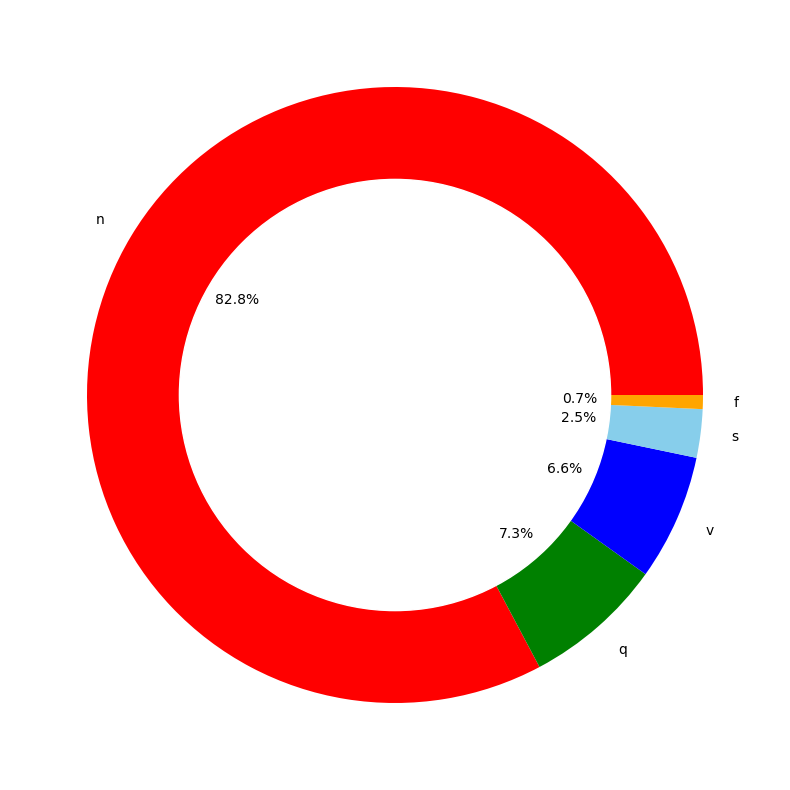

In [11]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

We can underligned a huge difference in the balanced of the classes. After some try i have decided to  choose the resample technique more than the class weights for the algorithms. 

In [12]:
#select number of trainsing samples to use
Ns = equilibre[0]
print(Ns)

72471


In [13]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=Ns,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=Ns,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=Ns,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=Ns,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=Ns,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [14]:
equilibre=train_df[187].value_counts()
print(equilibre)

187
0    72471
1    72471
2    72471
3    72471
4    72471
Name: count, dtype: int64


In [15]:
df_0.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
10153,0.162791,0.540698,0.755814,0.186047,0.168605,0.546512,0.616279,0.697674,0.651163,0.703488,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
33886,0.990066,0.938742,0.344371,0.034768,0.273179,0.331126,0.326159,0.341060,0.347682,0.347682,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
32005,0.974239,0.932084,0.590164,0.131148,0.014052,0.168618,0.238876,0.210773,0.196721,0.208431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
56159,0.978495,0.723118,0.526882,0.298387,0.220430,0.158602,0.091398,0.091398,0.080645,0.083333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
61783,0.963351,0.709424,0.060209,0.013089,0.057592,0.041885,0.047120,0.034031,0.039267,0.044503,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [16]:
df_1.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
72471,1.000000,0.666667,0.100457,0.036530,0.073059,0.050228,0.018265,0.105023,0.132420,0.091324,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1
72472,0.983696,1.000000,0.331522,0.000000,0.108696,0.163043,0.130435,0.190217,0.288043,0.222826,...,0.461957,0.483696,0.500000,0.494565,0.510870,0.51087,0.505435,0.472826,0.434783,1
72473,1.000000,0.911504,0.216814,0.000000,0.101770,0.199115,0.176991,0.194690,0.252212,0.238938,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1
72474,0.090498,0.126697,0.217195,0.361991,0.461538,0.556561,0.443439,0.434389,0.452489,0.511312,...,0.122172,0.131222,0.140271,0.158371,0.176471,0.20362,0.212670,0.000000,0.000000,1
72475,0.961111,1.000000,0.551852,0.101852,0.040741,0.085185,0.094444,0.088889,0.085185,0.070370,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1


In [17]:
df_1_upsample.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
73817,1.000000,0.622642,0.196226,0.316981,0.324528,0.316981,0.328302,0.339623,0.332075,0.343396,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
73593,1.000000,0.964286,0.185714,0.000000,0.114286,0.064286,0.114286,0.128571,0.271429,0.214286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
74237,0.863980,0.748111,0.168766,0.000000,0.105793,0.219144,0.221662,0.229219,0.239295,0.256927,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
74625,0.897436,0.851282,0.200000,0.000000,0.117949,0.179487,0.087179,0.143590,0.205128,0.138462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
73618,1.000000,0.672289,0.000000,0.004819,0.154217,0.168675,0.146988,0.115663,0.098795,0.091566,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


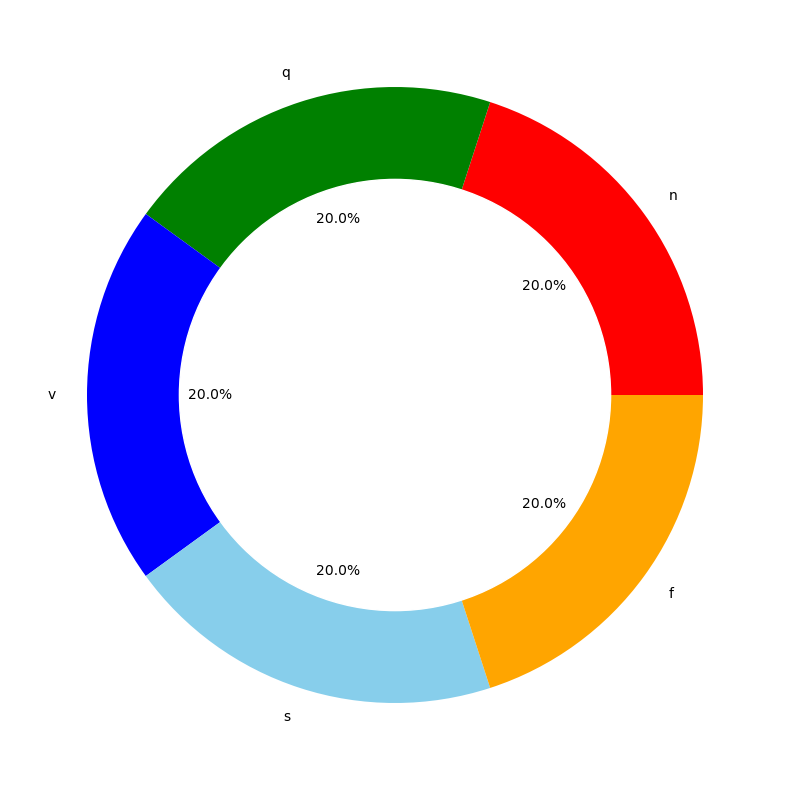

In [18]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

Resample works perfectly we can go on. 

**Classes**

In this part i want to study the differente classes. 

In [19]:
c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))

I take one sample per class and i store it in a datafrmae in order to have an exmeple. 

In [20]:
c

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
63537,1.000000,0.743161,0.360182,0.107903,0.000000,0.094225,0.139818,0.113982,0.113982,0.110942,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
73376,0.970814,0.920123,0.341014,0.000000,0.259601,0.302611,0.291859,0.307220,0.294931,0.288786,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
78211,1.000000,0.972556,0.658662,0.216124,0.000000,0.049743,0.106346,0.132075,0.216124,0.288165,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
80656,1.000000,0.790015,0.397944,0.108664,0.039648,0.146843,0.157122,0.132159,0.123348,0.113069,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
85907,0.949833,0.571906,0.608696,0.571906,0.561873,0.555184,0.521739,0.431438,0.331104,0.183946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


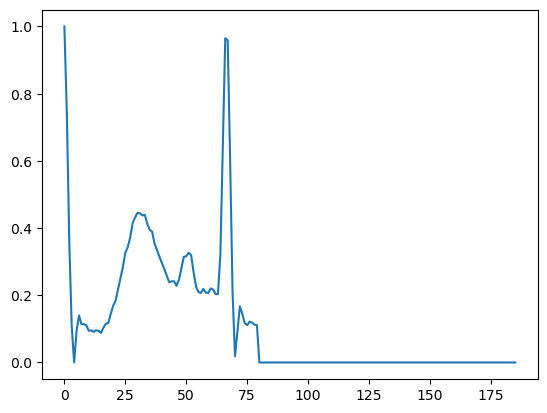

In [21]:
plt.plot(c.iloc[0,:186])

Here is a normal beat. I don't have something particular to say on that class.  

In [22]:
def plot_hist(class_number,size,min_,bins):
    img=train_df.loc[train_df[187]==class_number].values
    img=img[:,min_:size]
    img_flatten=img.flatten()

    final1=np.arange(min_,size)
    for i in range (img.shape[0]-1):
        tempo1=np.arange(min_,size)
        final1=np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(img_flatten))
    plt.hist2d(final1,img_flatten, bins=(bins,bins),cmap=plt.cm.jet)
    plt.show()

4710615
4710615


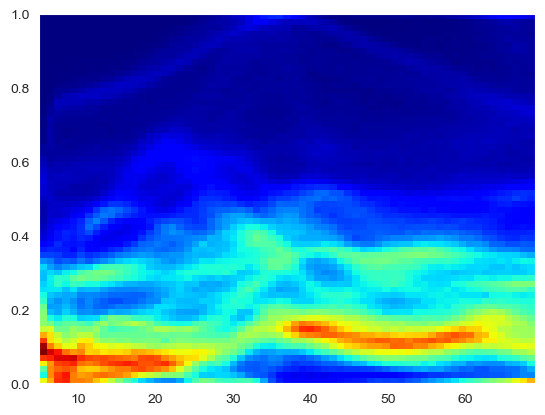

In [19]:
plot_hist(0,70,5,65)

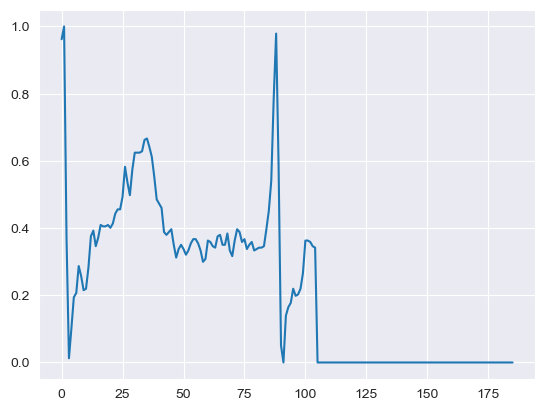

In [20]:
plt.plot(c.iloc[1,:186])

3261195
3261195


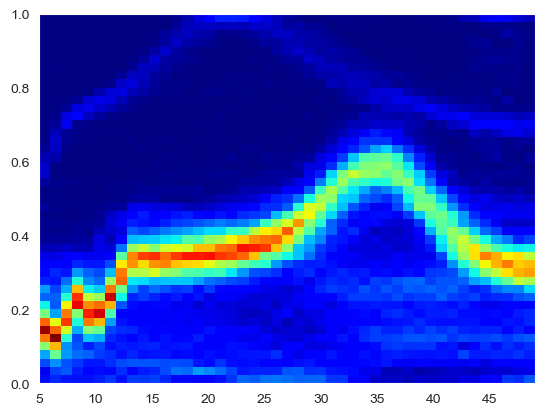

In [21]:
plot_hist(1,50,5,45)

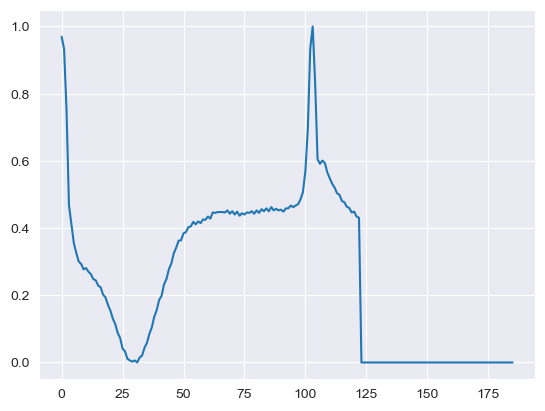

In [22]:
plt.plot(c.iloc[2,:186])

3261195
3261195


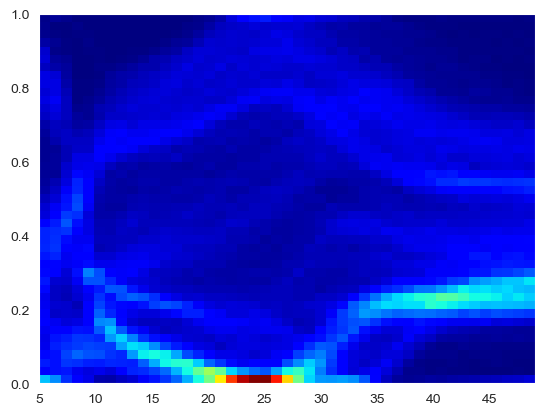

In [23]:
plot_hist(2,50,5,45)

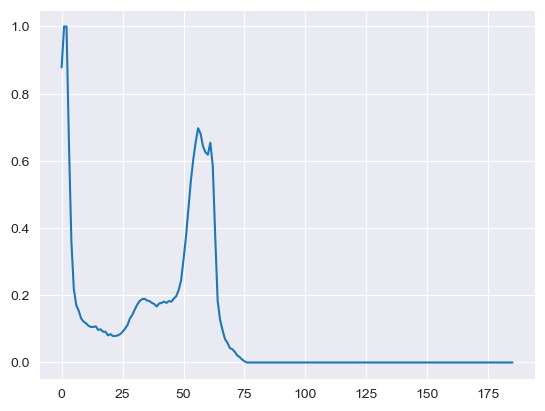

In [24]:
plt.plot(c.iloc[3,:186])

3261195
3261195


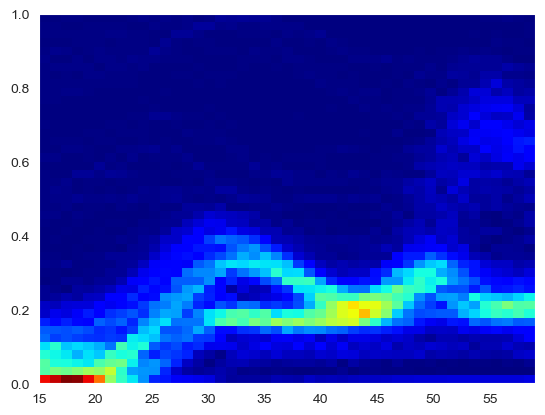

In [25]:
plot_hist(3,60,15,45)

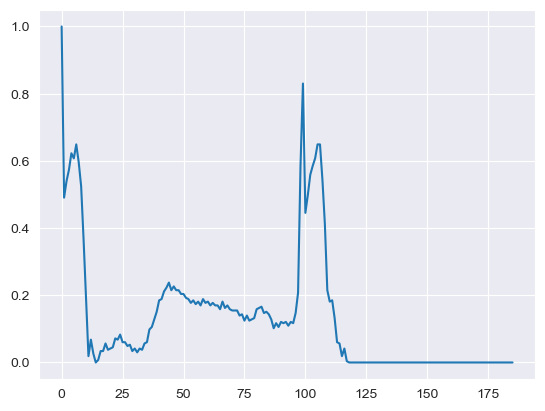

In [26]:
plt.plot(c.iloc[4,:186])

2536485
2536485


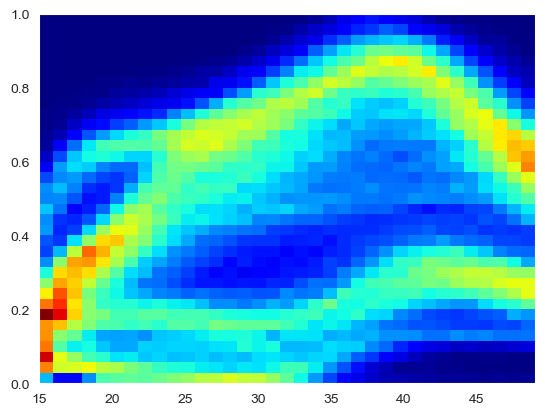

In [27]:
plot_hist(4,50,15,35)

In [23]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.1,186)
    return (signal+noise)


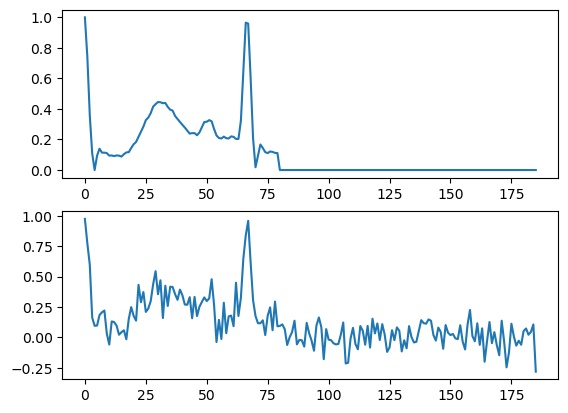

In [24]:
tempo=c.iloc[0,:186]
bruiter=add_gaussian_noise(tempo)

plt.subplot(2,1,1)
plt.plot(c.iloc[0,:186])

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()



In [25]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [26]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
for i in range(len(X_train)):
    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

**Network**

In [31]:
def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='LeakyReLU', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='LeakyReLU', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='LeakyReLU', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='LeakyReLU')(flatten)
    dense_end2 = Dense(32, activation='LeakyReLU')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=20,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [32]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)
    

In [33]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
model,history=network(X_train,y_train,X_test,y_test)

Epoch 1/20


2023-11-05 20:54:14.192508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11324/11324 [==============================] - ETA: 0s - loss: 0.2457 - accuracy: 0.9103

2023-11-05 21:03:36.791615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11324/11324 [==============================] - 590s 52ms/step - loss: 0.2457 - accuracy: 0.9103 - val_loss: 0.3408 - val_accuracy: 0.8656
Epoch 2/20
11324/11324 [==============================] - 565s 50ms/step - loss: 0.1495 - accuracy: 0.9453 - val_loss: 0.2374 - val_accuracy: 0.9183
Epoch 3/20
11324/11324 [==============================] - 554s 49ms/step - loss: 0.1222 - accuracy: 0.9551 - val_loss: 0.1690 - val_accuracy: 0.9448
Epoch 4/20
11324/11324 [==============================] - 555s 49ms/step - loss: 0.1075 - accuracy: 0.9603 - val_loss: 0.2174 - val_accuracy: 0.9249
Epoch 5/20
11324/11324 [==============================] - 607s 54ms/step - loss: 0.0964 - accuracy: 0.9645 - val_loss: 0.2489 - val_accuracy: 0.9205
Epoch 6/20
11324/11324 [==============================] - 651s 57ms/step - loss: 0.0892 - accuracy: 0.9673 - val_loss: 0.1855 - val_accuracy: 0.9394
Epoch 7/20
11324/11324 [==============================] - 671s 59ms/step - loss: 0.0837 - accuracy: 0.9694 - val_loss

Accuracy: 94.48%


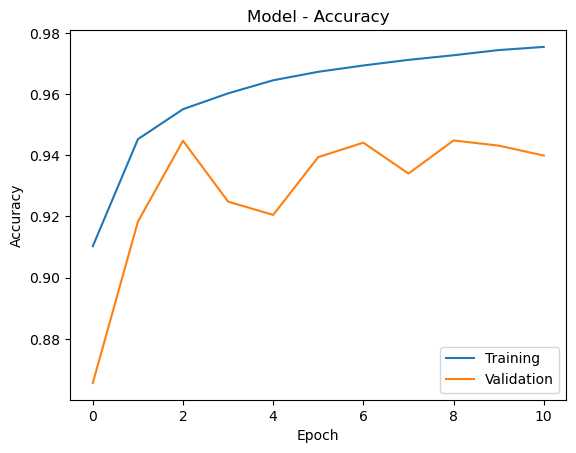

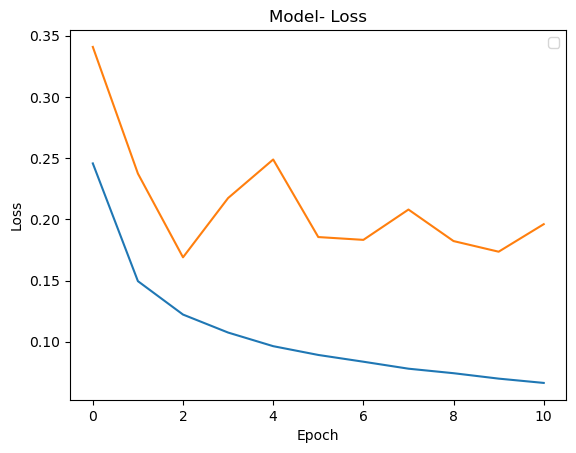

2023-11-06 00:16:16.789804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


685/685 [==============================] - 2s 3ms/step


In [34]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

Normalized confusion matrix


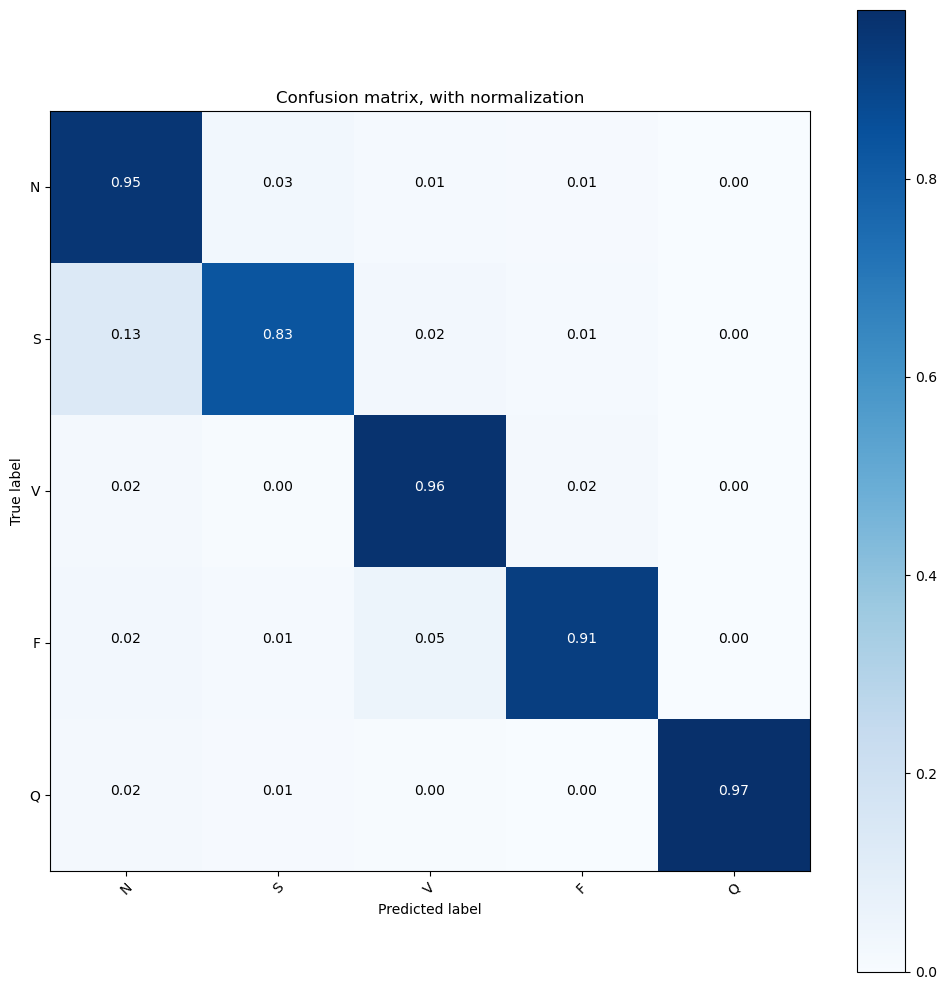

In [35]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

